In [3]:
import numpy as np
import pandas as pd
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.ensemble import RandomForestClassifier
from time import time

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn import metrics
from copy import deepcopy
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
def read_files_df(path1, n):
  articles = pd.read_csv(path1)
  articles = articles[:n]
  #customers = pd.read_csv(path2)
  #transactions = pd.read_csv(path3)

  cols_ = []
  # categorical features and their article id
  articles_part = articles[['article_id','prod_name','product_type_name','product_group_name','graphical_appearance_name','colour_group_name'
                         ,'perceived_colour_value_name','perceived_colour_master_name','department_name','index_name','index_group_name'
                         ,'section_name','garment_group_name','detail_desc']]
  
  for i in articles_part.columns[1:]:
    articles_part[i] = articles_part[i].str.replace(" ", "")
    cols_.append(i)
  # merging texts
  articles_part['merged'] =  articles_part[cols_].apply(lambda x: ' '.join(x.values.astype(str)), axis=1)
  final_data = articles_part[[articles_part.columns[0], articles_part.columns[-1]]]
  final_data['merged'] = final_data['merged'].fillna('')
  indices = pd.Series(final_data.index, index=final_data['article_id'].drop_duplicates())

  # vectorization
  vectorizer = TfidfVectorizer(stop_words='english')
  matr_ = vectorizer.fit_transform(final_data['merged'])

  # check the first two representation
  #check_representation = matr_.todense()
  #df = pd.DataFrame(check_representation, columns = vectorizer.get_feature_names(), index=['first', 'second'])
  #df

  # preform cosine similarity
  cosine_sim_ = cosine_similarity(matr_, matr_)

  return final_data, cosine_sim_, indices

def textCleaning(text):
    cleaned_text = ''
    manup_text = []
    word_process = [PorterStemmer(), WordNetLemmatizer(), set(stopwords.words('english'))]
    text = re.sub(r"\n|(\\(.*?){)|}|[!$%^&*#()_+|~\-={}\[\]:\";'<>?,.\/\\]|[0-9]|[@]", ' ', text)
    # avoid extra space
    text = re.sub('\s+', ' ', text)
    for word in text.split():
      w = word_process[0].stem(word.lower())
      w = word_process[1].lemmatize(w, pos='v')
      if w not in word_process[2]:
        manup_text.append(w)
    cleaned_text = ' '.join(manup_text)
    return cleaned_text

def crossValidation(clf, train_X, train_y, folds=5, c=" "):
    kf = StratifiedKFold(n_splits=folds)
    start_time = time()
    train_scores = []
    counter = 1
    clf_ = deepcopy(clf)
    avg_accuracy = 0
    for tr_index, tes_index in kf.split(train_X, train_y):
        cv_clf = deepcopy(clf_)
        if c == "NB":
          print("Computed F-%d : NB" % counter)
        elif c == "RF":
          print("Computed F-%d : RF" % counter)
        counter += 1
        train_X_, train_y_, test_X_, test_y_ = train_X[tr_index], train_y[tr_index], train_X[tes_index], train_y[tes_index]
        cv_clf.fit(train_X_, train_y_)
        pred = cv_clf.predict(test_X_)
        scores = {}
        scores['accuracy'] = metrics.accuracy_score(test_y_, pred)
        scores['recall'] = metrics.recall_score(test_y_, pred, average='macro')
        scores['precision'] = metrics.precision_score(test_y_, pred, average='macro')
        scores['f1_score'] = metrics.f1_score(test_y_, pred, average='macro')
        train_scores.append(scores)
        avg_accuracy += scores['accuracy']
    train_time = time() - start_time
    print("Average Accuracy and time for validation: %0.3f : %0.3f " % (avg_accuracy/folds, train_time))
    return train_scores, train_time


In [6]:
file_1 = "/content/drive/MyDrive/DataIntensive-500/articles.csv"
file_3 = pd.read_csv("/content/drive/MyDrive/DataIntensive-500/transactions_train.csv")

In [7]:
all_articles = pd.read_csv(file_1)
all_articles["labels"] = 0

for i in range(1000):
  if str(all_articles.article_id[i]).startswith("1"):
    all_articles["labels"][i] = 1
  elif str(all_articles.article_id[i]).startswith("2"):
    all_articles["labels"][i] = 2
  elif str(all_articles.article_id[i]).startswith("3"):
    all_articles["labels"][i] = 3
  elif str(all_articles.article_id[i]).startswith("4"):
    all_articles["labels"][i] = 4
  elif str(all_articles.article_id[i]).startswith("5"):
    all_articles["labels"][i] = 5
  elif str(all_articles.article_id[i]).startswith("6"):
    all_articles["labels"][i] = 6
  elif str(all_articles.article_id[i]).startswith("7"):
    all_articles["labels"][i] = 7
  elif str(all_articles.article_id[i]).startswith("8"):
    all_articles["labels"][i] = 8
  elif str(all_articles.article_id[i]).startswith("9"):
    all_articles["labels"][i] = 9
  else:
    pass 

In [8]:
n = 20000 # the number of rows to work with
final_data, cosine_sim_, indices = read_files_df(file_1, n)
texts = list(final_data.merged)
# this will be replce by the nine groups(in this case the first 1000 rows)
#arti_id = list(final_data.article_id)
arti_id = all_articles[:20000].labels

all_texts = []
for text in texts:
  sent = textCleaning(text)
  all_texts.append(sent)

In [9]:
# creating our new-data set 
new_df = pd.DataFrame(list(zip(all_texts, arti_id)), columns =['texts', 'article_target'])
train_X, test_X, train_y, test_y = train_test_split(new_df.texts, new_df.article_target, test_size=0.3, stratify=new_df.article_target)
train_X = pd.Series(list(train_X), index=range(0, len(train_X)))
train_y = pd.Series(list(train_y), index=range(0, len(train_y)))

# Convert all text data into tf-idf vectors 
vectorizer = TfidfVectorizer(stop_words='english', min_df=2)
train_vec = vectorizer.fit_transform(train_X)
test_vec = vectorizer.transform(test_X)

experiments = np.logspace(2, 3, num=10, base=10, dtype='int')
nb_cv_scores = []
nb_cv_times = []
RandomForest_cv_scores = []
RandomForest_cv_times = []

for n_l_docs in experiments:
    nb_clf = MultinomialNB(alpha=1e-2)
    RandomForest_clf = RandomForestClassifier(max_depth=2, random_state=0)
    cv_scores, cv_time = crossValidation(nb_clf, train_vec[:n_l_docs,], train_y[:n_l_docs], c= "NB")
    cv_scores_2, cv_time_2 = crossValidation(RandomForest_clf, train_vec[:n_l_docs,], train_y[:n_l_docs], c="RF")
    nb_cv_scores.append(cv_scores)
    RandomForest_cv_scores.append(cv_scores)
    nb_cv_times.append(cv_time)
    RandomForest_cv_scores.append(cv_scores_2)
    RandomForest_cv_times.append(cv_time_2)


Computed F-1 : NB
Computed F-2 : NB
Computed F-3 : NB
Computed F-4 : NB
Computed F-5 : NB
Average Accuracy and time for validation: 0.940 : 0.048 
Computed F-1 : RF
Computed F-2 : RF
Computed F-3 : RF
Computed F-4 : RF
Computed F-5 : RF
Average Accuracy and time for validation: 0.940 : 0.816 
Computed F-1 : NB
Computed F-2 : NB
Computed F-3 : NB
Computed F-4 : NB
Computed F-5 : NB
Average Accuracy and time for validation: 0.946 : 0.043 
Computed F-1 : RF
Computed F-2 : RF
Computed F-3 : RF
Computed F-4 : RF
Computed F-5 : RF
Average Accuracy and time for validation: 0.946 : 0.801 
Computed F-1 : NB
Computed F-2 : NB
Computed F-3 : NB
Computed F-4 : NB
Computed F-5 : NB
Average Accuracy and time for validation: 0.952 : 0.042 
Computed F-1 : RF
Computed F-2 : RF
Computed F-3 : RF
Computed F-4 : RF
Computed F-5 : RF
Average Accuracy and time for validation: 0.958 : 0.861 
Computed F-1 : NB
Computed F-2 : NB
Computed F-3 : NB
Computed F-4 : NB
Computed F-5 : NB
Average Accuracy and time fo

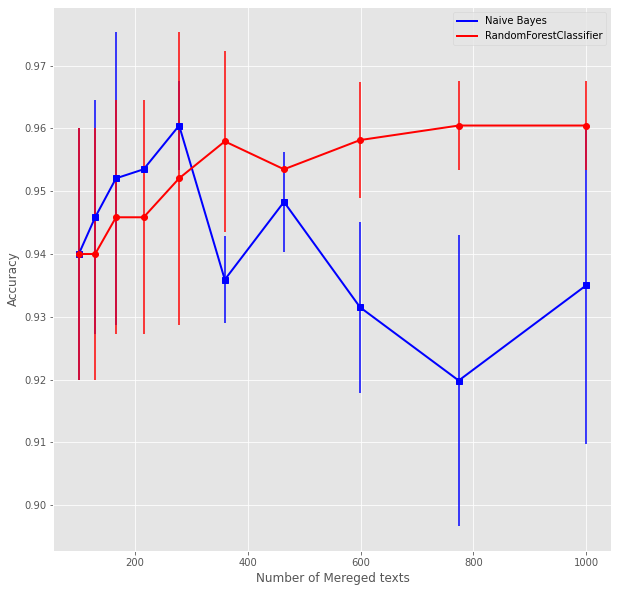

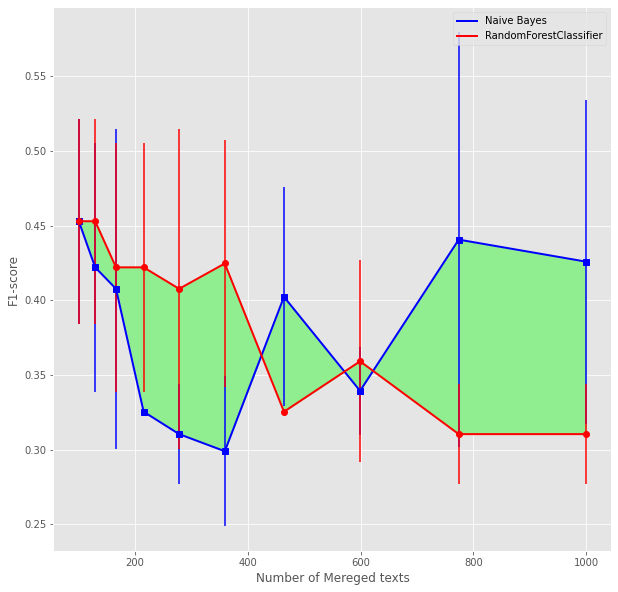

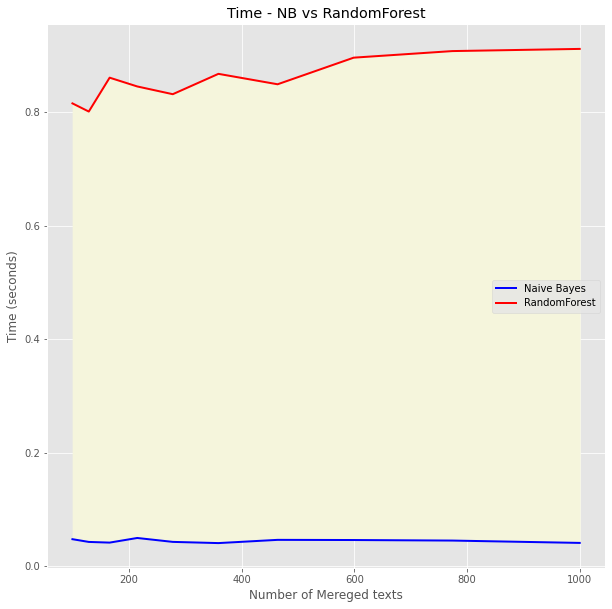

In [33]:
# plot crossValidation accuracy comparisons
nb_score_mean = []
nb_score_err = []
RandomForest_nb_score_mean = []
RandomForest_nb_score_err = []
for idx in range(len(experiments)):
    nb_scores = [value['accuracy'] for value in nb_cv_scores[idx]]
    nb_score_mean.append(np.mean(nb_scores))
    nb_score_err.append(np.std(nb_scores))
    RandomForest_nb_scores = [value['accuracy'] for value in RandomForest_cv_scores[idx]]
    RandomForest_nb_score_mean.append(np.mean(RandomForest_nb_scores))
    RandomForest_nb_score_err.append(np.std(RandomForest_nb_scores))
plt.style.use('ggplot')
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_score_mean, color='b', linewidth=2, label='Naive Bayes')
ax.errorbar(experiments, nb_score_mean, yerr=nb_score_err, fmt='s', color='b')
ax.plot(experiments, RandomForest_nb_score_mean, color='r', linewidth=2, label='RandomForestClassifier')
ax.errorbar(experiments, RandomForest_nb_score_mean, yerr=RandomForest_nb_score_err, fmt='o', color='r')
ax.set_xlabel('Number of Mereged texts')
ax.set_ylabel('Accuracy')
plt.legend(loc='upper right')
#plt.savefig("./accuracy_Samples.pdf", bbox_inches="tight")
plt.show()
#plot crossValidation accuracy comparisons
nb_score_mean = []
nb_score_err = []
RandomForest_nb_score_mean = []
RandomForest_nb_score_err = []
for idx in range(len(experiments)):
    nb_scores = [value['f1_score'] for value in nb_cv_scores[idx]]
    nb_score_mean.append(np.mean(nb_scores))
    nb_score_err.append(np.std(nb_scores))
    RandomForest_nb_scores = [value['f1_score'] for value in RandomForest_cv_scores[idx]]
    RandomForest_nb_score_mean.append(np.mean(RandomForest_nb_scores))
    RandomForest_nb_score_err.append(np.std(RandomForest_nb_scores))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_score_mean, color='b', linewidth=2, label='Naive Bayes')
ax.errorbar(experiments, nb_score_mean, yerr=nb_score_err, fmt='s', color='b')
ax.plot(experiments, RandomForest_nb_score_mean, color='r', linewidth=2, label='RandomForestClassifier')
ax.errorbar(experiments, RandomForest_nb_score_mean, yerr=RandomForest_nb_score_err, fmt='o', color='r')
ax.fill_between(experiments, nb_score_mean, RandomForest_nb_score_mean, color='lightgreen')
ax.set_xlabel('Number of Mereged texts')
ax.set_ylabel('F1-score')
plt.legend(loc='upper right')
#plt.savefig("./fl_score_Samples.pdf", bbox_inches="tight")
#plot time consuming in NB training process
plt.show()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_cv_times, color='b', linewidth=2, label='Naive Bayes')
ax.plot(experiments, RandomForest_cv_times, color='r', linestyle='-', linewidth=2, label='RandomForest')
ax.fill_between(experiments, nb_cv_times, RandomForest_cv_times, color='beige')
ax.set_xlabel('Number of Mereged texts')
ax.set_ylabel('Time (seconds)')
plt.title('Time - NB vs RandomForest')
plt.legend(loc='center right')
#plt.savefig("./time_comp_Samples.pdf", bbox_inches="tight")
plt.show()
